In [97]:
import gzip
import itertools
import string
import wordcloud
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pylab as pl
from pandas.io.json import json_normalize
import json 
import csv 
import glob
from collections import Counter
from sklearn import svm
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
%matplotlib inline

In [19]:
#Converting json to csv then to dataframe
#one time activity
# with open("Beauty_5.json") as f: 
#     data = [json.loads(line) for line in f]

# # now we will open a file for writing 
# data_file = open('data_file.csv', 'w') 
  
# # create the csv writer object 
# csv_writer = csv.writer(data_file) 
  
# # Counter variable used for writing  
# # headers to the CSV file 
# count = 0
  
# for emp in data: 
#     if count == 0: 
  
#         # Writing headers of CSV file 
#         header = emp.keys() 
#         csv_writer.writerow(header) 
#         count += 1
  
#     # Writing data of CSV file 
#     csv_writer.writerow(emp.values()) 

# data_file.close()

  
 

In [117]:
#reading csv
data=pd.read_csv('data_file.csv')


In [118]:
#convert to datetime format

data['reviewTime']= pd.to_datetime(data['reviewTime'], errors='coerce')

#filling missing dates
data['reviewTime']=data['reviewTime'].fillna(data['reviewTime'].mean())

#select only dates
data['reviewTime'] = data['reviewTime'].dt.date

#fill or replace summary nan's with OK product
data['summary'] = data['summary'].replace(np.nan, 'OK product', regex=True)

#fill or replace reviewtext nan's with OK product
data['reviewText'] = data['reviewText'].replace(np.nan, 'OK product', regex=True)

#fill missing values with mode for reviewer name
data['reviewerName'] = data['reviewerName'].fillna(data['reviewerName'].mode().iloc[0])

In [119]:
products = data['overall'].groupby(data['asin']).count()
print("Number of Unique Products in the Beauty Category = {}".format(products.count()))

Number of Unique Products in the Beauty Category = 13483


In [120]:
sorted_products = products.sort_values(ascending=False)

print("Top 10 Reviewed Products:\n")
print(sorted_products[:10], end='\n\n')
print('Most Reviewed Product, B004OHQR1Q - has {} reviews.'.format(products.max()))

Top 10 Reviewed Products:

asin
B004OHQR1Q    431
B0043OYFKU    401
B0069FDR96    391
B000ZMBSPE    389
B00150LT40    328
B003V265QW    328
B006L1DNWY    321
B008U1Q4DI    309
B007BLN17K    305
B000142FVW    302
Name: overall, dtype: int64

Most Reviewed Product, B004OHQR1Q - has 431 reviews.


In [121]:
stops = stopwords.words('english')

In [122]:
def tokenize(text):
    tokenized = word_tokenize(text)
    no_punc = []
    for review in tokenized:
        line = "".join(char for char in review if char not in string.punctuation)
        no_punc.append(line)
    tokens = lemmatize(no_punc)
    return tokens


def lemmatize(tokens):
    lmtzr = WordNetLemmatizer()
    lemma = [lmtzr.lemmatize(t) for t in tokens]
    return lemma

In [141]:
#tokenize the reviewtext column
reviews=data['reviewText']
reviews = reviews.apply(lambda x: tokenize(x))


In [105]:
cloud = wordcloud.WordCloud(background_color='gray', max_font_size=60, 
                                relative_scaling=1).generate(' '.join(data.reviewText))

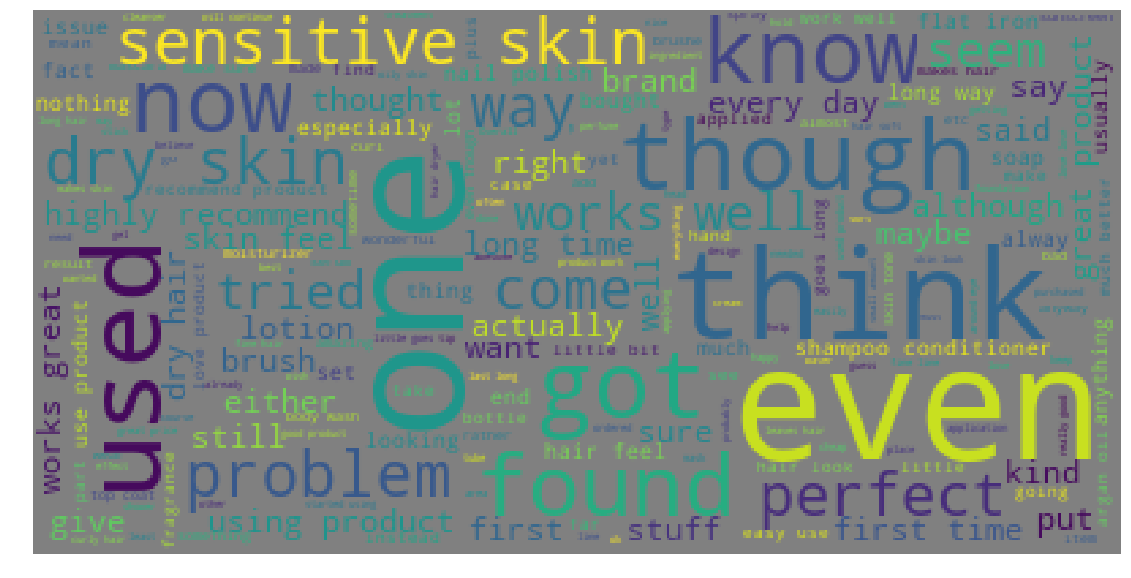

In [106]:
fig = plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(cloud);

In [ ]:
#any string value which is not digit
data['overall'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')

#replace the result with nan's to impute it later with average value
data['overall']=data['overall'].replace(r'^\s*$', np.nan, regex=True)

#replace other values which are not nan's and nor [1,2,3,4,5] because values are in 10,20,and 30's format
data['overall']=data['overall'].replace(['3','5','6','4','7','9829','1','2','21','35','1349','52','100','1001','112','9096'], '30')    

#replace nan's from 2nd step with the 3's
data['overall'] = data['overall'].replace(np.nan, '30', regex=True)

#strip 0's to correct format ie. 1,2,3,4,5 instead of 10,20,30,40,50
data['overall'] = data['overall'].map(lambda x: x.rstrip('0'))



In [140]:
#encode new column for negative and positive reviews
#0 for negative and 1 for positive reviews
#1-3 rating corresponds to negative and rest is positive
data['overall']=data['overall'].astype(int)

data['pos_neg'] = [1 if x > 3 else 0 for x in data.overall]

In [143]:
review_text=data['reviewText']

In [144]:
#split training and test set
x_train, x_test, y_train, y_test = train_test_split(data.reviewText, data.pos_neg, random_state=0)

In [145]:
# Vectorize X_train
vectorizer = CountVectorizer(min_df=5).fit(x_train)
X_train = vectorizer.transform(x_train)

In [146]:
feature_names = vectorizer.get_feature_names()
print("Number of features: {}".format(len(feature_names)))

Number of features: 19547


In [148]:
#logistic regression and accuracy
scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.3f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.863


In [149]:
logreg = LogisticRegression(C=0.1).fit(X_train, y_train)

X_test = vectorizer.transform(x_test)

log_y_pred = logreg.predict(X_test)

logreg_score = accuracy_score(y_test, log_y_pred)
print("Accuracy:   {:.3f}".format(logreg_score))

In [151]:

#training and test set errors
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))



Training set score: 0.880
Test set score: 0.865


In [152]:
#confusion matrix
log_cfm = confusion_matrix(y_test, log_y_pred)
print("Confusion matrix:")
print(log_cfm, end='\n\n')
print('-'*15)
print(np.array([['TN', 'FP'],[ 'FN' , 'TP']]))

Confusion matrix:
[[ 6664  4708]
 [ 2007 36247]]

---------------
[['TN' 'FP']
 ['FN' 'TP']]


In [153]:

#f1 scores
log_f1 = f1_score(y_test, log_y_pred)
print("Logistic Reg - F1 score: {:.3f}".format(log_f1))



Logistic Reg - F1 score: 0.915


In [154]:
#grid search cv with different hyperparameters
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best cross-validation score: {:.3f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [156]:
print("{:.3f}".format(grid.score(X_test, y_test)))

0.865


In [157]:
grid_log_f1 = f1_score(y_test, log_y_pred)
print("Grid Logistic Reg - F1 score: {:.3f}".format(grid_log_f1))


Grid Logistic Reg - F1 score: 0.915


In [159]:
cnf_matrix = confusion_matrix(y_test, log_y_pred)

In [160]:
#TfidfVectorizer with Pipeline through GridSearchCV
pipeline = make_pipeline(TfidfVectorizer(min_df=5, norm=None),
                     LogisticRegression())
tfidf_param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

tfidf_grid = GridSearchCV(pipeline, tfidf_param_grid, cv=5)
tfidf_grid.fit(x_train, y_train)

print("Best cross-validation score: {:.3f}".format(tfidf_grid.best_score_))
print("Best parameters: ", tfidf_grid.best_params_)

Best cross-validation score: 0.864
Best parameters:  {'logisticregression__C': 0.001}


In [163]:
#for multiclass splitting
x_train, x_test, y_train, y_test = train_test_split(data.reviewText, data.overall, random_state=0)
# Vectorize X_train
vectorizer = CountVectorizer(min_df=5).fit(x_train)
X_train = vectorizer.transform(x_train)
feature_names = vectorizer.get_feature_names()
print("Number of features: {}".format(len(feature_names)))


Number of features: 19547


In [166]:
#performing multiclass
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import StandardScaler
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
#ovo_clf.fit(X_train, y_train)

scores = cross_val_score(ovo_clf, X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.3f}".format(np.mean(scores)))


##with standardized for more accuracy
# scaler=StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
# cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3, scoring="accuracy")

Mean cross-validation accuracy: 0.653


In [167]:
ovo_reg = ovo_clf.fit(X_train, y_train)

X_test = vectorizer.transform(x_test)

ovo_y_pred = ovo_reg.predict(X_test)

ovo_score = accuracy_score(y_test, ovo_y_pred)
print("Accuracy:   {:.3f}".format(ovo_score))

Accuracy:   0.651


In [168]:
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))


Training set score: 0.011
Test set score: 0.012


In [169]:
log_cfm = confusion_matrix(y_test, log_y_pred)
print("Confusion matrix:")
print(log_cfm, end='\n\n')
print('-'*15)
print(np.array([['TN', 'FP'],[ 'FN' , 'TP']]))

Confusion matrix:
[[ 1335   388   319    30   572]
 [  579   614   846    78   759]
 [  276   568  2195   379  2434]
 [  110   182  1465  1141  6999]
 [  189   132   625   386 27025]]

---------------
[['TN' 'FP']
 ['FN' 'TP']]


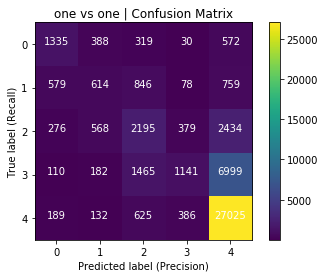

In [171]:
plt.imshow(log_cfm, interpolation='nearest')

for i, j in itertools.product(range(log_cfm.shape[0]), range(log_cfm.shape[1])):
    plt.text(j, i, log_cfm[i, j],
             horizontalalignment="center",
             color="white")

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('one vs one | Confusion Matrix')
plt.colorbar();

In [172]:
cross_val_score(sgd_clf,	X_train,	y_train,	cv=3,	scoring="accuracy")

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [174]:
sgd_clf=SGDClassifier(random_state=42)
cross_val_score(sgd_clf, X_train, y_train, cv=3,scoring="accuracy")

array([0.65002217, 0.64793955, 0.6497733 ])

In [ ]:

from sklearn.ensemble import RandomForestClassifier
tfidf = TfidfVectorizer(min_df=5)
x_train_input = tfidf.fit_transform(x_train)

rand = RandomForestClassifier()
rand.fit(x_train_input, y_train)
y_rand_predicted = rand.predict(tfidf.transform(x_test))



In [ ]:
modelEvaluation(y_rand_predicted, y_test)

In [ ]:


print ("Accuracy of Random Forest = " + str(rand.score(tfidf.transform(x_test), y_test)))
print ("Fscore of this SVM = " + str(metrics.precision_recall_fscore_support(y_test, y_predicted, pos_label=2, average='weighted')))
print ("F-1 score of this SVM = " + str(metrics.f1_score(y_test, y_predicted, pos_label=2, average='weighted')))
print ("confusion matrix = " + str(metrics.confusion_matrix(y_test, y_predicted)))



In [179]:
def modelEvaluation(predictions, y_test_set):
    #Print model evaluation to predicted result 
    
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test_set, predictions)))
    #print "\nAUC score : {:.4f}".format(roc_auc_score(y_test_set, predictions))
    print ("\nClassification report : \n", metrics.classification_report(y_test_set, predictions))
    print ("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test_set, predictions))